In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time # delay within program
from math import *
import random
import pickle
import os

import nidaqmx # laser output
from pyueye import ueye
from pypyueye import Camera

from improc import *

# Inits and checks

In [2]:
templates,bodies = load_templates()
cam,task = init_instruments()

In [3]:
bgs = make_vec_bg(cam,task,[0,1],total_time=10)

In [9]:
cam.exit()

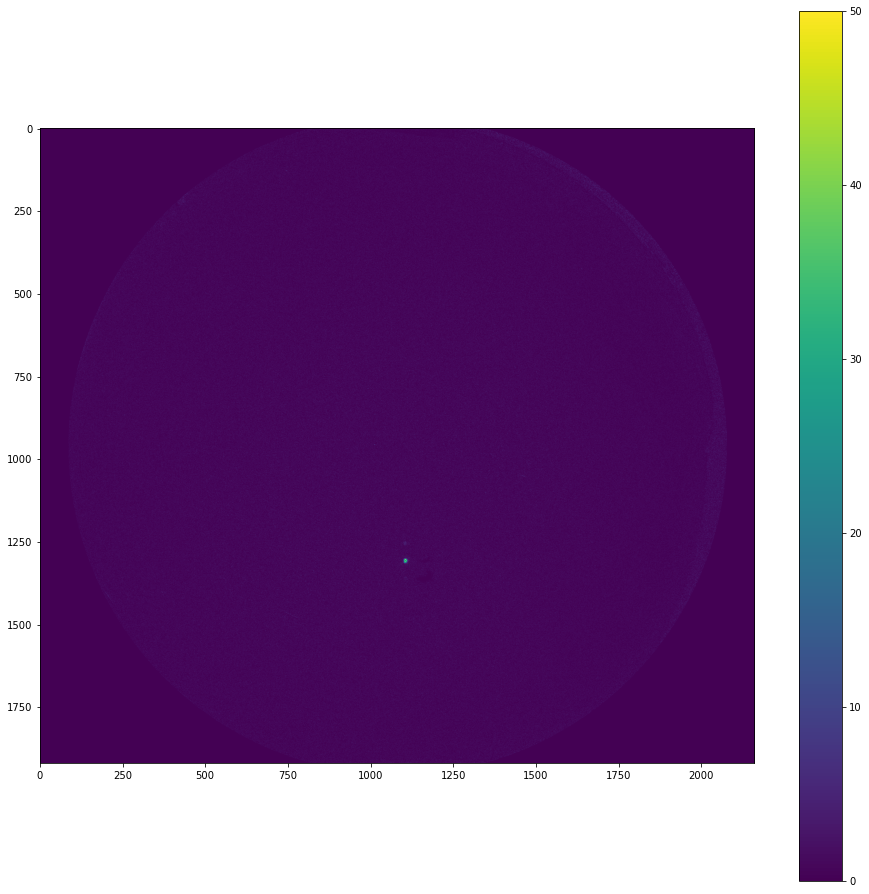

In [4]:
# Check that things are working
plt.figure(figsize=(16,16))
img = grab_im(cam,bgs[0])
plt.imshow(img)
plt.colorbar();

[{'loc': array([1103.58024691, 1307.79012346]), 'img': array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 2, 0, 0],
       [2, 0, 2, ..., 0, 2, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 1],
       [0, 0, 2, ..., 1, 1, 1],
       [3, 0, 2, ..., 0, 1, 0]], dtype=uint8), 'scores': array([362888, 298586]), 'angs': array([150, 210]), 'endpts': array([[1100, 1100],
       [1303, 1313]]), 'body': 60}]


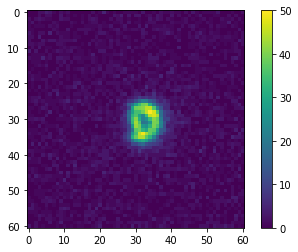

In [5]:
worms = find_worms(img,templates,bodies)
print(worms)
plt.imshow(worms[0]['img'])
plt.colorbar();

# AIY test

In [8]:
track,angs,lights = if_stmt_angle(90,cam,task,bgs,templates,bodies,total_time=60)

Finding orientation
elapsed 2

1
	 1239.68 -1377.66
	body 300 head 270 light 0
2
	 1242.65 -1383.31
	body 300 head 0 light 1
3
	 1244.61 -1387.13
	body 300 head 300 light 0
5
	 1246.65 -1390.88
	body 300 head 270 light 0
6
	 1249.94 -1395.08
	body 300 head 0 light 1
7
	 1251.86 -1396.58
	body 330 head 300 light 0
9
	 1254.29 -1398.73
	body 330 head 270 light 0
10
	 1257.84 -1400.97
	body 330 head 30 light 1
11
	 1260.41 -1402.29
	body 330 head 330 light 0
13
	 1264.25 -1404.0
	body 330 head 330 light 0
14
	 1267.41 -1405.12
	body 330 head 90 light 1
15
	 1270.73 -1405.31
	body 330 head 0 light 1
17
	 1274.45 -1405.44
	body 30 head 330 light 0
18
	 1277.75 -1405.46
	body 30 head 60 light 1
19
	 1279.63 -1404.91
	body 330 head 90 light 1
21
	 1280.91 -1404.67
	body 30 head 0 light 0
22
	 1283.08 -1404.45
	body 30 head 300 light 0
23
	 1284.67 -1404.34
	body 30 head 0 light 0
25
	 1287.13 -1404.0
	body 30 head 60 light 1
26
	 1290.27 -1402.25
	body 30 head 90 light 1
27
	 1292.47 -1399.92

In [48]:
task.write(0)

1

In [7]:
np.save('Data/09_09_track1.npy',track)
np.save('Data/09_09_angles1.npy',angs)
np.save('Data/09_09_lights1.npy',lights)

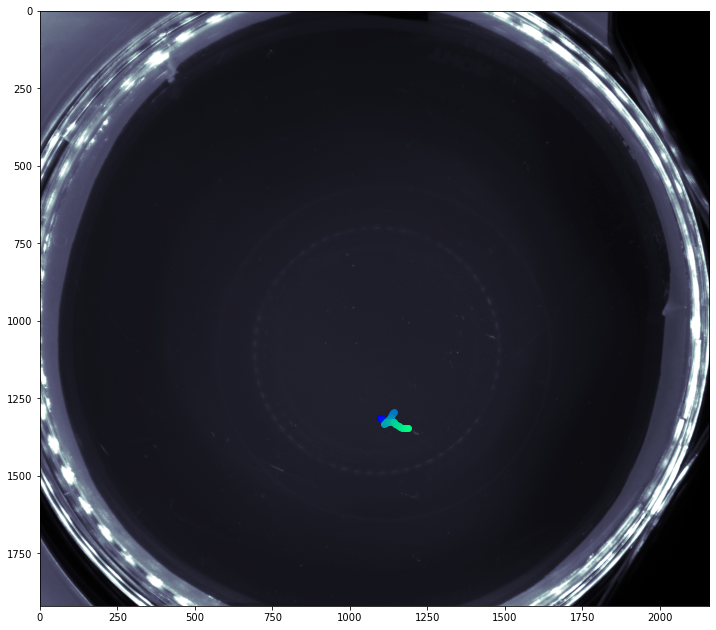

In [7]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

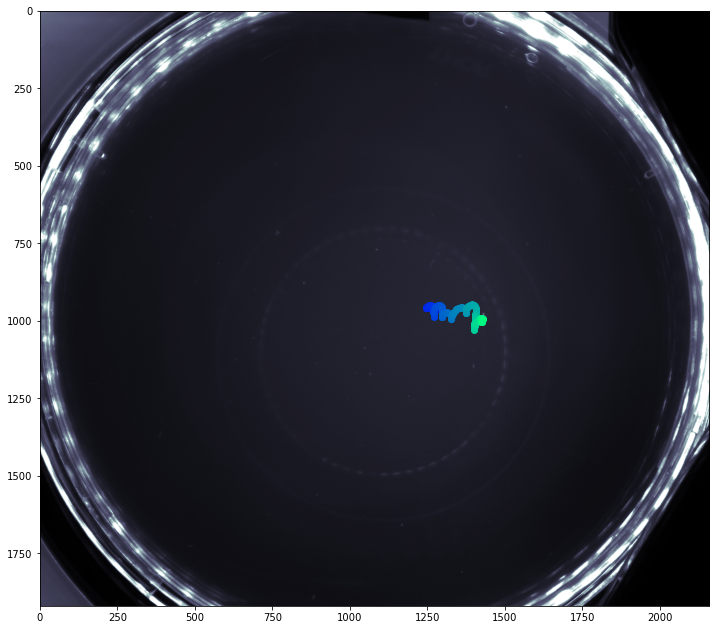

In [24]:
fig,ax = plt.subplots(1)
img = grab_im(cam,None)
ax.imshow(img,cmap='bone')
fig.set_size_inches((12,12))
NPOINTS = track.shape[0]
ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in range(NPOINTS-1):
    ax.scatter(track[i,1],track[i,2])
    ax.set_aspect('equal','box')

# TD

In [2]:
import numpy as np

In [11]:
n_states = (5,5,2)

In [12]:
np.random.normal(scale=0.1,size=n_states)

array([[[-0.00170421,  0.12679642],
        [-0.14437924,  0.10979055],
        [-0.08687421, -0.03612811],
        [-0.14941281,  0.13396834],
        [-0.11568418,  0.00162673]],

       [[-0.08212039, -0.01546229],
        [ 0.02026113, -0.00382057],
        [-0.07233205,  0.02864773],
        [ 0.03862163, -0.08523815],
        [ 0.01847405,  0.12227938]],

       [[-0.19856336,  0.03418477],
        [ 0.14360898, -0.035058  ],
        [-0.04152788,  0.26669876],
        [-0.0511283 , -0.01312185],
        [-0.01152458,  0.01531509]],

       [[-0.29330916, -0.03604903],
        [ 0.04713274,  0.07871975],
        [ 0.05804218, -0.08026749],
        [-0.10321168, -0.03249952],
        [ 0.11081974,  0.15195065]],

       [[-0.11942378, -0.09285244],
        [-0.0119971 ,  0.08516889],
        [-0.2728197 , -0.24667368],
        [-0.07630626,  0.01460227],
        [ 0.07552377,  0.0272074 ]]])

In [67]:
def tabular_Q_agent(direction,light_vec,f_ind,Q_chkpt=None,t_chkpt=0,delay=0,alpha=.05,gamma=0.9,total_time=600,track_time=10,ht_time=3):
    # Fills in a value table theta x light, where light is discretized as in light_vec.
    # delay is how much time in sec between each sample
    # alpha is the learning rate for averaging
    # total_time is in seconds
    # direction is target direction.
    
    # Q_chkpt and t_chkpt are to continue previous trials. Q_chkpt takes the last np array of Q values and 
    # t_chkpt is the approximate last time.
    
    data_dir = './Data/'
    
    NUM_DEGS = 12 # 12 for 30 degree increments
    DEG_INCR = int(360/NUM_DEGS)
    
    def get_eps(t, start=1, end=.1, tau=total_time/4):
        # Returns the epsilon value at t given a start eps, end, and time constant
        # For exponential decay:
        #return (start-end)*np.exp(-t/tau) + end  
        # For constant (good for initial tests):
        return .1
    
    
    # Initialization block
    if Q_chkpt is None:
        Q_table = np.random.randn(NUM_DEGS,NUM_DEGS,len(light_vec))  # random init for now
    else:
        Q_table = Q_chkpt
    Q_obs = [[[[] for i in range(2)] for j in range(NUM_DEGS)] for k in range(NUM_DEGS)] # keep track of updates
        # The 24's above are the number of options [-180,180) in increments of 15
    track = []
    rewards = []
    bg = bgs[0]    
    START = True
    state_inds = [0,0]
    
    # Initialize starting points to junk
    head,old_loc = [1,1],[2,2]

    # Initialize all timers
    elapsed = Timer(total_time)
    track_el = Timer(track_time)
    ht_el = Timer(ht_time)  
    
    while not elapsed.check(): 
        
        # Collect image and make sure worm exists
        img = grab_im(cam,bg)
        worms = find_worms(img,templates,bodies,ref_pts=[head],num_worms=1)
        
        if worms is None:
            task.write(0)
            bg = bgs[0]
            print("Worm not found")
            continue
        worm = worms[0]
        head = worm['endpts'][:,0]
        
        
        # Update table block
        # light_ind and state_ind should still be from previous loop
        if START:
            reward = 0
        else:
            reward = proj(worm['loc']-last_loc, [np.cos(direction*pi/180),-np.sin(direction*pi/180)]) # Get reward
            if np.isnan(reward) or np.abs(reward)>10:
                reward = 0
        old_state_inds = state_inds
        last_loc = worm['loc']
        rewards.append(reward)
        
        # finding state
        body_dir = relative_angle(worm['body'],direction)
        head_body = relative_angle(worm['angs'][0],worm['body'])
        state_inds = [int((body_dir+180)//DEG_INCR), int((head_body+180)//DEG_INCR)]
        
        if not START:
            # Q table update step:
            # Q_t+1 (s,a) <- Q_t(s,a) + alpha([r+gamma*max_a'(Q_t(s',a'))] - Q_t(s,a))
            Q_table[old_state_inds[0],old_state_inds[1],light_ind] = \
                Q_table[old_state_inds[0],old_state_inds[1],light_ind] + \
                alpha*((reward+gamma*np.max(Q_table[state_inds[0],state_inds[1],:])) - \
                       Q_table[old_state_inds[0],old_state_inds[1],light_ind])
            
            Q_obs[old_state_inds[0]][old_state_inds[1]][light_ind].append(reward)

        
        # Light selection and action block
        eps = get_eps(elapsed.t+t_chkpt)
        if np.random.random() < eps or START:
            light_ind = random.choice(range(len(light_vec)))
            light = light_vec[light_ind]
            START = False
        else:
            # Choose greedy action
            light_ind = np.argmax(Q_table[state_inds[0],state_inds[1],:])
            light = light_vec[light_ind]
        task.write(light)
        bg = bgs[light_ind]
        
        
        # Tracking block
        if track_el.check():
            track.append(np.hstack([elapsed.t,worm['loc']]))
            #print('Time',int(elapsed.t)+t_chkpt,'\tang:',int(worm['body']),'loc:',worm['loc'])
            #print('\tReward:',round(reward,3))
            with open(data_dir+'Qtab_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_table, f)
            with open(data_dir+'Qobs_running'+f_ind+'.json','wb') as f:
                pickle.dump(Q_obs, f)
            with open(data_dir+'Track_running'+f_ind+'.json','wb') as f:
                pickle.dump(track, f)
            with open(data_dir+'Rewards_running'+f_ind+'.json','wb') as f:
                pickle.dump(rewards, f)

        if ht_el.check():
            head,SWITCH = ht_quick(worm,old_loc)
            old_loc = worm['loc']
#             if SWITCH:
#                 print('\t\tSwitched')
        
        # Update maintenance variables and step delay
        elapsed.update()
        track_el.update()
        ht_el.update()
        time.sleep(delay)
    
    task.write(0)
    return np.array(track),Q_table,np.array(rewards)

On hour: 5.0
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Mean rewards: 0.1312
On hour: 5.75


C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not f

C:\Users\ccli3\Documents\Research\20_09_07_NewPC\Worms4TF\improc.py:205: RuntimeWarning: invalid value encountered in longlong_scalars
  centers.append(np.array([np.sum(np.arange(im_sz)*sumx) / np.sum(sumx), np.sum(np.arange(im_sz)*sumy) / np.sum(sumy)]))


Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found
Worm not found


KeyboardInterrupt: 

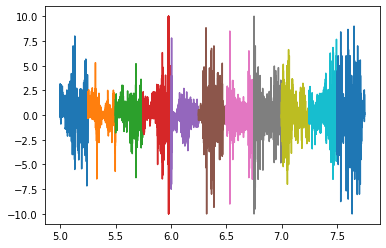

In [75]:
data_dir = './Data/'
track = []
Qs = []
rewards = []
start_hr = 5
last_Q = int(start_hr/.25)-1
Qtab = np.load(data_dir+'Qtab_'+'917_'+str(last_Q)+'.json',allow_pickle=True)

for hr in np.arange(64-last_Q)+last_Q+1: # Run for many hours, fingers crossed
    print('On hour:',round(hr/4,3))
    flabel = '917_'+str(hr)
    
    bgs = make_vec_bg(cam,task,[0,1],total_time=20)
    tr,Q,Rs = tabular_Q_agent((90*hr)%360,[0,1],flabel,Q_chkpt=Qtab,t_chkpt=900*hr,alpha=0.05,total_time=900)
    track.append(tr)
    Qs.append(Q)
    rewards.append(Rs)
    
    with open(data_dir+'Qtab_'+flabel+'.json','wb') as f:
        pickle.dump(Q, f)
    with open(data_dir+'Track_'+flabel+'.json','wb') as f:
        pickle.dump(tr, f)
    with open(data_dir+'Rewards_'+flabel+'.json','wb') as f:
        pickle.dump(Rs, f)
    
    Qtab = np.load(data_dir+'Qtab_'+flabel+'.json',allow_pickle=True)
    print('Mean rewards:',round(np.mean(Rs),4))
    
    plt.plot(np.linspace(hr/4,hr/4+1/4,len(Rs)),Rs)

In [76]:
task.write(0)

1

In [ ]:
flabel = '909'
with open(data_dir+'Qtab_fin_'+flabel+'.json','wb') as f:
    pickle.dump(Qs, f)
with open(data_dir+'Track_fin_'+flabel+'.json','wb') as f:
    pickle.dump(track, f)
with open(data_dir+'Rewards_fin_'+flabel+'.json','wb') as f:
    pickle.dump(rewards, f)

In [10]:
task.write(0)

1

In [ ]:
all_rewards = []
for i in range(1):
     all_rewards.append(np.load('Data/Rewards_916_'+str(i)+'.json',allow_pickle=True))

In [17]:
all_rewards = np.hstack(all_rewards)

In [18]:
all_rewards.shape

(46658,)

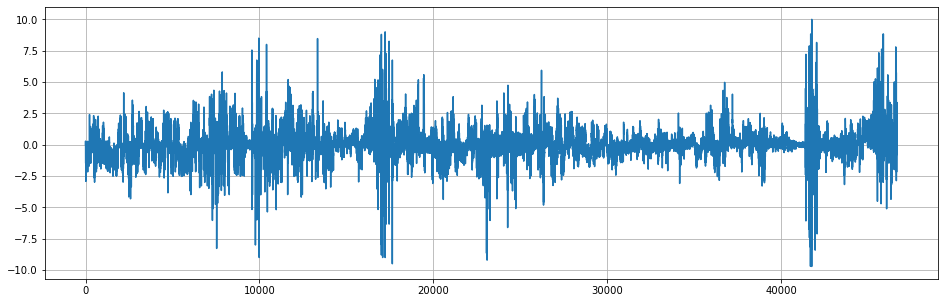

In [21]:
plt.figure(figsize=(16,5));
plt.plot(all_rewards)
plt.grid()